In [89]:
import pandas as pd
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import xgboost as xgb
import pickle
from functools import reduce



# basket analysis

## load and clean

In [2]:
csv_path = "./online_retail_II.csv"
json_path = "./prob_dict.json"

"""load data"""
df = pd.read_csv(csv_path)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
"""first-step cleaning:"""

# 1. drop rows non UK and then drop country column
df = df.drop(df[df["Country"] != "United Kingdom"].index)
df = df.drop(columns=["Country"])
# 2. drop description column
df = df.drop(columns=["Description"])
# 3. drop rows with negative or 0 quantity
df = df.drop(df[df["Quantity"] <= 0].index)
# 4. drop rows with negative or 0 price
df = df.drop(df[df["Price"] <= 0].index)
# 5. drop invoice column starting with letters (cancelations)
df = df.drop(df[df["Invoice"].str.contains("^[a-zA-Z]", regex=True)].index)
# 6. only keep rows with stock code starting with 5 digits
df = df[df["StockCode"].str.contains("^[0-9]{5}", regex=True)]

# 7. convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID
0,489434,85048,12,2009-12-01 07:45:00,6.95,13085.0
1,489434,79323P,12,2009-12-01 07:45:00,6.75,13085.0
2,489434,79323W,12,2009-12-01 07:45:00,6.75,13085.0
3,489434,22041,48,2009-12-01 07:45:00,2.10,13085.0
4,489434,21232,24,2009-12-01 07:45:00,1.25,13085.0


In [4]:
"""second-step cleaning:"""
# we only need to know which Invoice contains which product
df_basket = df[["Invoice", "StockCode"]]

# only save the top n most frequent products 
num_top = 5

# show in each invoice which products were bought
invoice_products = df_basket.groupby('Invoice')['StockCode'].unique().to_frame(name='products')
invoice_products.head()

,products
Invoice,
489434,"[85048, 79323P, 79323W, 22041, 21232, 22064, 2..."
489435,"[22350, 22349, 22195, 22353]"
489436,"[48173C, 21755, 21754, 84879, 22119, 22142, 22..."
489437,"[22143, 22145, 22130, 21364, 21360, 21351, 213..."
489438,"[21329, 21252, 21100, 21033, 20711, 21410, 214..."


In [5]:
"""calculation of invoice support (conditional probability)"""

count_dict = {}
prob_dict = {}

# iterrate over all invoices
for _, row in tqdm(invoice_products.iterrows(), total=len(invoice_products), ascii=True):
    products = row['products']
    for product_a in products:
        count_dict[product_a] = count_dict.get(product_a, 0) + 1
        if product_a not in prob_dict:
            prob_dict[product_a] = {}
        for product_b in products:
            if product_a != product_b:
                prob_dict[product_a][product_b] = prob_dict[product_a].get(product_b, 0) + 1

# calculate conditional probability
for product_a in tqdm(prob_dict, total=len(prob_dict), ascii=True):
    for product_b in prob_dict[product_a]:
        prob_dict[product_a][product_b] /= count_dict[product_a]

# sort by probability (descending) and only keep the top5
for product in tqdm(prob_dict, total=len(prob_dict), ascii=True):
    prob_dict[product] = {k: v for k, v in sorted(prob_dict[product].items(), key=lambda item: item[1], reverse=True)}
    prob_dict[product] = {k: v for k, v in list(prob_dict[product].items())[:num_top]}


100%|##########| 4867/4867 [00:04<00:00, 986.16it/s] 


In [6]:
"""save the conditional probability dictionary as json file"""
with open('prob_dict.json', 'w') as fp:
    json.dump(prob_dict, fp) 

In [7]:
"""load the conditional probability dictionary from json file"""
with open('prob_dict.json', 'r') as fp:
    prob_dict = json.load(fp)

For the product 82482, the top 5 products with highest probability are:
82494L: 0.5394063459570113
85123A: 0.40276356192425794
82483: 0.2436028659160696
82486: 0.23541453428863868
85099B: 0.21699078812691913


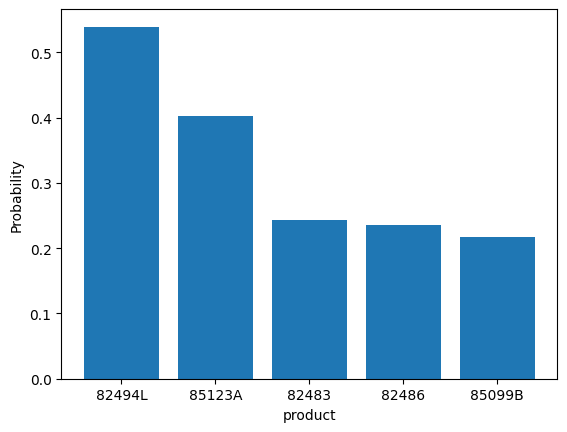

In [8]:
def show_top(prob_dict, product, num=num_top):
    # make sure the product is in the dictionary, num is positive and smaller than num_top
    assert product in prob_dict.keys()
    assert num > 0
    assert num <= num_top

    interesting_dict = prob_dict[product]
    key_list = list(interesting_dict.keys())[:num]
    val_list = list(interesting_dict.values())[:num]

    # display the top n products with probability
    print(f"For the product {product}, the top {num} products with highest probability are:")
    for i in range(num):
        print(f"{key_list[i]}: {val_list[i]}")

    # visualize
    plt.bar(key_list, val_list)
    plt.xlabel("product")
    plt.ylabel("Probability")
    plt.show()

show_top(prob_dict, "82482")

# returned customers

In [145]:
"""load and clean data"""
csv_path = "./online_retail_II.csv"
model_path = "./model.pkl"

"""load data"""
df = pd.read_csv(csv_path)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [146]:
"""cleaning:"""

def clean(df):
    # 1. drop rows non UK and then drop country column
    df = df.drop(df[df["Country"] != "United Kingdom"].index)
    df = df.drop(columns=["Country"])
    # 2. drop description column
    df = df.drop(columns=["Description"])
    # 3. drop rows with negative or 0 quantity
    df = df.drop(df[df["Quantity"] <= 0].index)
    # 4. drop rows with negative or 0 price
    df = df.drop(df[df["Price"] <= 0].index)
    # 5. drop invoice column starting with letters (cancelations)
    df = df.drop(df[df["Invoice"].str.contains("^[a-zA-Z]", regex=True)].index)
    # 6. only keep rows with stock code starting with 5 digits
    df = df[df["StockCode"].str.contains("^[0-9]{5}", regex=True)]
    # 7. convert InvoiceDate to datetime
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
    # 8. drop rows with missing values
    df = df.dropna()
    # 9. convert CustomerID to int
    df["Customer ID"] = df["Customer ID"].astype(int)
    # 10. calculate total price
    df["TotalPrice"] = df["Quantity"] * df["Price"]
    # 11. convert StockCode to its respective index
    # get a unique list of StockCode
    stock_code_list = df["StockCode"].unique().tolist()
    # get a dict of StockCode and its index and the reverse
    stock_code_dict = {stock_code_list[i]: i for i in range(len(stock_code_list))}
    df["StockCode"] = df["StockCode"].apply(lambda x: stock_code_dict[x])
    return df, stock_code_dict
# need the dict for future use
df, stock_code_dict = clean(df)

df.head()

,Invoice,StockCode,Quantity,InvoiceDate,Price,Customer ID,TotalPrice
0,489434,0,12,2009-12-01 07:45:00,6.95,13085,83.4
1,489434,1,12,2009-12-01 07:45:00,6.75,13085,81.0
2,489434,2,12,2009-12-01 07:45:00,6.75,13085,81.0
3,489434,3,48,2009-12-01 07:45:00,2.10,13085,100.8
4,489434,4,24,2009-12-01 07:45:00,1.25,13085,30.0


In [147]:
"""get dataframe of Customer ID and corresponding invoices (unique)"""

grouped_data = df.groupby('Customer ID').agg({
    'Invoice': lambda invoices: list(invoices.unique())  # Convert invoices to lists
}).reset_index()
grouped_data.columns = ['Customer ID', 'Invoice']
grouped_data.head()

,Customer ID,Invoice
0,12346,"[499763, 513774, 541431]"
1,12608,[529807]
2,12745,"[508457, 518560]"
3,12746,[512627]
4,12747,"[490678, 491045, 492300, 497572, 498399, 50072..."


In [149]:
"""get useful information of each invoice"""
invoice_data = df.groupby(['Invoice']).agg({
    'Quantity': "sum",
    "TotalPrice": "sum",
    "InvoiceDate": "first",
    "StockCode": lambda x: list(x.unique())
}).reset_index()

invoice_data.head()

(33361, 5)

In [140]:
"""prepare data for model"""
feature_list = []
label_list = []
start_year = 2009


# get the quarter count of a date (from 2099)
def quarter_count(date):
    date = pd.to_datetime(date)
    return (date.year - start_year) * 4 + date.quarter

max_quater = max(list(invoice_data["InvoiceDate"].apply(lambda x: quarter_count(x))))

# tell if a costomer has bought in the next certain quarter
def get_label(quater_count, quarter_list):
    if quater_count + 1 in quarter_list:
        return 1
    else:
        return 0

# iterrate over all customers
for i, row in tqdm(grouped_data.iterrows(), total=len(grouped_data), ascii=True):
    invoice_list = row['Invoice']
    date_list = invoice_data[invoice_data['Invoice'].isin(invoice_list)]['InvoiceDate'].tolist()
    date_list = [quarter_count(date) for date in date_list]
    date_list_unique = sorted(list(set(date_list)))

    # for each unique quarter, get the corresponding invoices and calculate the features
    for date in date_list_unique:
        # the last quarter is not used for training
        if date == max_quater:
            continue
        list_index = [invoice_list[i] for i, x in enumerate(date_list) if x == date]
        selected_invoices = invoice_data[invoice_data['Invoice'].isin(list_index)]
        union_list = reduce(lambda x, y: set(x).union(y), selected_invoices['StockCode'])
        feature_list.append([selected_invoices['Quantity'].sum(), selected_invoices['Quantity'].mean(), 
                             selected_invoices['TotalPrice'].sum(), selected_invoices['TotalPrice'].mean(),
                             date%4, len(union_list), union_list, get_label(date, date_list_unique)])

# convert to dataframe
feature_df = pd.DataFrame(feature_list, columns=['Quantity_sum', 'Quantity_mean', 'TotalPrice_sum', 'TotalPrice_mean', 'Quarter', 'types', 'type_list', 'Label'])


100%|##########| 5334/5334 [01:14<00:00, 71.54it/s] 


In [141]:
"""encode the types and quarter because they are categorical"""
mlb = MultiLabelBinarizer()
# encode the types (1 if bought, 0 if not)
one_hot_encoded_df = pd.DataFrame(mlb.fit_transform(feature_df['type_list']), columns=mlb.classes_)
feature_df = pd.concat([feature_df, one_hot_encoded_df], axis=1).drop(columns=['type_list'])

# encode the quarter (one hot)
one_hot = pd.get_dummies(feature_df['Quarter'])
# set one hot column names "Quarter_0", "Quarter_1", etc. to avoid confusion
one_hot.columns = ["Quarter_" + str(i) for i in range(4)]
feature_df = pd.concat([feature_df, one_hot], axis=1)

In [142]:
# view the classes distribution in the dataset
print(feature_df['Label'].value_counts())

# view the quarter distribution in the dataset
print(feature_df['Quarter'].value_counts())

1    8127
0    5996
Name: Label, dtype: int64
3    3817
2    3691
0    3361
1    3254
Name: Quarter, dtype: int64


In [143]:
"""the label is balanced but the quarter is not balanced, so we randomly drop 2000 rows with quarter 0"""

# randomly drop 2000 rows with Label 1
feature_df = feature_df.drop(feature_df[feature_df['Label'] == 1].sample(n=2000, random_state=42).index)

# view the classes distribution in the dataset
print(feature_df['Label'].value_counts())

# view the quarter distribution in the dataset
print(feature_df['Quarter'].value_counts())

1    6127
0    5996
Name: Label, dtype: int64
3    3241
2    3132
0    2972
1    2778
Name: Quarter, dtype: int64


In [144]:
# split the data into train and test sets
labels = feature_df['Label']
features = feature_df.drop(columns=['Label', 'Quarter'])
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)

with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    # train random forest with hyperparameter tuning
    rf_best_model = None
    rf_best_score = 0
    rf_best_i = 0
    rf_best_j = 0
    rf_list_record = []

    # iterrate over all possible hyperparameters
    for i in tqdm(range(60, 200, 20), ascii=True):
        for j in (3, 5, 7, 9, 11, 13):
            model = RandomForestClassifier(n_estimators=i, max_depth=j,  random_state=1)
            model.fit(X_train, y_train)
            train_score = model.score(X_train, y_train)
            score = model.score(X_test, y_test)
            rf_list_record.append([i, j, train_score, score])
            print(f"n_estimators: {i}, max_depth: {j}, train_score: {train_score}, test_score: {score}")
            if score > rf_best_score:
                rf_best_score = score
                rf_best_model = model
                rf_best_i = i
                rf_best_j = j

    print(f"best score: {rf_best_score}, best i: {rf_best_i}, best j: {rf_best_j}")

  0%|          | 0/7 [00:00<?, ?it/s]

n_estimators: 60, max_depth: 3, train_score: 0.6462157145803259, test_score: 0.6424742268041237
n_estimators: 60, max_depth: 5, train_score: 0.6576613734790678, test_score: 0.6453608247422681
n_estimators: 60, max_depth: 7, train_score: 0.670138172819138, test_score: 0.6457731958762887
n_estimators: 60, max_depth: 9, train_score: 0.6934419467931532, test_score: 0.6441237113402062
n_estimators: 60, max_depth: 11, train_score: 0.7163332645906373, test_score: 0.6511340206185567


 14%|#4        | 1/7 [00:17<01:44, 17.41s/it]

n_estimators: 60, max_depth: 13, train_score: 0.7413899773149103, test_score: 0.6593814432989691
n_estimators: 80, max_depth: 3, train_score: 0.6495153639925758, test_score: 0.6412371134020619
n_estimators: 80, max_depth: 5, train_score: 0.6603423386265209, test_score: 0.6503092783505154
n_estimators: 80, max_depth: 7, train_score: 0.671787997525263, test_score: 0.6482474226804124
n_estimators: 80, max_depth: 9, train_score: 0.6949886574551454, test_score: 0.6523711340206185
n_estimators: 80, max_depth: 11, train_score: 0.7213858527531449, test_score: 0.6531958762886598


 29%|##8       | 2/7 [00:37<01:33, 18.77s/it]

n_estimators: 80, max_depth: 13, train_score: 0.7461332233450196, test_score: 0.6581443298969072
n_estimators: 100, max_depth: 3, train_score: 0.6516807589193648, test_score: 0.6465979381443299
n_estimators: 100, max_depth: 5, train_score: 0.6614765931119818, test_score: 0.6527835051546391
n_estimators: 100, max_depth: 7, train_score: 0.6748814188492472, test_score: 0.6511340206185567
n_estimators: 100, max_depth: 9, train_score: 0.6955042276758094, test_score: 0.6490721649484537
n_estimators: 100, max_depth: 11, train_score: 0.7191173437822231, test_score: 0.6515463917525773


 43%|####2     | 3/7 [01:00<01:23, 20.81s/it]

n_estimators: 100, max_depth: 13, train_score: 0.7448958548154259, test_score: 0.657319587628866
n_estimators: 120, max_depth: 3, train_score: 0.6465250567127243, test_score: 0.6494845360824743
n_estimators: 120, max_depth: 5, train_score: 0.6601361105382553, test_score: 0.650721649484536
n_estimators: 120, max_depth: 7, train_score: 0.6745720767168488, test_score: 0.6515463917525773
n_estimators: 120, max_depth: 9, train_score: 0.6941637451020829, test_score: 0.6490721649484537
n_estimators: 120, max_depth: 11, train_score: 0.7188080016498247, test_score: 0.6519587628865979


 57%|#####7    | 4/7 [01:26<01:08, 22.84s/it]

n_estimators: 120, max_depth: 13, train_score: 0.7472674778304805, test_score: 0.6548453608247423
n_estimators: 140, max_depth: 3, train_score: 0.6480717673747164, test_score: 0.6474226804123712
n_estimators: 140, max_depth: 5, train_score: 0.6607547948030522, test_score: 0.6548453608247423
n_estimators: 140, max_depth: 7, train_score: 0.6740565064961848, test_score: 0.650721649484536
n_estimators: 140, max_depth: 9, train_score: 0.6959166838523407, test_score: 0.6457731958762887
n_estimators: 140, max_depth: 11, train_score: 0.7184986595174263, test_score: 0.6548453608247423


 71%|#######1  | 5/7 [01:56<00:50, 25.49s/it]

n_estimators: 140, max_depth: 13, train_score: 0.745926995256754, test_score: 0.6597938144329897
n_estimators: 160, max_depth: 3, train_score: 0.6480717673747164, test_score: 0.6441237113402062
n_estimators: 160, max_depth: 5, train_score: 0.6610641369354506, test_score: 0.6519587628865979
n_estimators: 160, max_depth: 7, train_score: 0.6740565064961848, test_score: 0.6478350515463918
n_estimators: 160, max_depth: 9, train_score: 0.6945762012786142, test_score: 0.6503092783505154
n_estimators: 160, max_depth: 11, train_score: 0.7179830892967622, test_score: 0.6548453608247423


 86%|########5 | 6/7 [02:30<00:28, 28.32s/it]

n_estimators: 160, max_depth: 13, train_score: 0.7472674778304805, test_score: 0.6589690721649485
n_estimators: 180, max_depth: 3, train_score: 0.6464219426685914, test_score: 0.6445360824742268
n_estimators: 180, max_depth: 5, train_score: 0.6610641369354506, test_score: 0.6515463917525773
n_estimators: 180, max_depth: 7, train_score: 0.6737471643637863, test_score: 0.650721649484536
n_estimators: 180, max_depth: 9, train_score: 0.694679315322747, test_score: 0.6515463917525773
n_estimators: 180, max_depth: 11, train_score: 0.7184986595174263, test_score: 0.6560824742268041


100%|##########| 7/7 [03:09<00:00, 27.06s/it]

n_estimators: 180, max_depth: 13, train_score: 0.7479892761394102, test_score: 0.657319587628866
best score: 0.6597938144329897, best i: 140, best j: 13


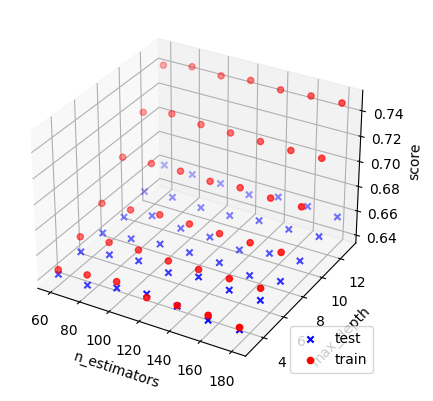

In [86]:
# visualize the rf_list_record as figure
i_values = [item[0] for item in rf_list_record]
j_values = [item[1] for item in rf_list_record]
train_score_values = [item[2] for item in rf_list_record]
score_values = [item[3] for item in rf_list_record]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(i_values, j_values, score_values, c='b', marker='x')
ax.scatter(i_values, j_values, train_score_values, c='r', marker='o')
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('score')
plt.legend(["test", "train"], loc ="lower right")
plt.show()

# The deeper the tree is, the more likely it is to overfit (though with higher score).
# since 65% is not a good score, we try xgboost


In [85]:
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    # train random forest with hyperparameter tuning
    xgb_best_model = None
    xgb_best_score = 0
    xgb_best_i = 0
    xgb_best_j = 0
    xgb_list_record = []


    for i in tqdm([0.05, 0.1, 0.2, 0.3], ascii=True):
        for j in (3, 5):
            model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, verbose=1, learning_rate=i, max_depth=j)
            model.fit(X_train, y_train)
            train_score = model.score(X_train, y_train)
            score = model.score(X_test, y_test)
            xgb_list_record.append([i, j, train_score, score])
            print(f"lr: {i}, max_depth: {j}, train_score: {train_score}, test_score: {score}")
            if score > xgb_best_score:
                xgb_best_score = score
                xgb_best_model = model
                xgb_best_i = i
                xgb_best_j = j

    print(f"best score: {xgb_best_score}, best i: {xgb_best_i}, best j: {xgb_best_j}")



  0%|          | 0/4 [00:00<?, ?it/s]

[14:25:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


lr: 0.05, max_depth: 3, train_score: 0.6831305423798721, test_score: 0.6742268041237114
[14:26:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




 25%|##5       | 1/4 [01:11<03:33, 71.25s/it]

lr: 0.05, max_depth: 5, train_score: 0.7176737471643638, test_score: 0.6684536082474227
[14:26:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


lr: 0.1, max_depth: 3, train_score: 0.6977727366467313, test_score: 0.6738144329896907
[14:27:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such ca

 50%|#####     | 2/4 [02:22<02:22, 71.49s/it]

lr: 0.1, max_depth: 5, train_score: 0.7467519076098165, test_score: 0.6684536082474227
[14:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


lr: 0.2, max_depth: 3, train_score: 0.7258197566508559, test_score: 0.6696907216494845
[14:28:27] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cas

 75%|#######5  | 3/4 [03:41<01:14, 74.75s/it]

lr: 0.2, max_depth: 5, train_score: 0.7844916477624252, test_score: 0.6643298969072164
[14:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


lr: 0.3, max_depth: 3, train_score: 0.739946380697051, test_score: 0.6684536082474227
[14:29:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such case

100%|##########| 4/4 [04:51<00:00, 72.83s/it]

lr: 0.3, max_depth: 5, train_score: 0.8094452464425654, test_score: 0.6577319587628866
best score: 0.6742268041237114, best i: 0.05, best j: 3


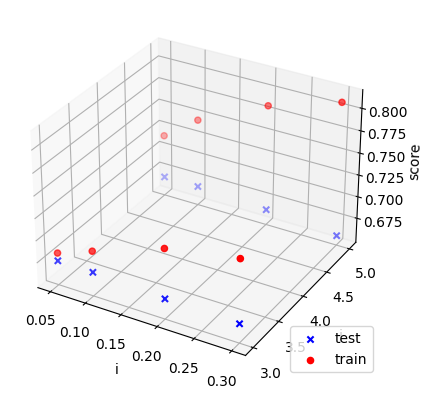

In [87]:
# visualize the _list_record as figure
i_values = [item[0] for item in xgb_list_record]
j_values = [item[1] for item in xgb_list_record]
train_score_values = [item[2] for item in xgb_list_record]
score_values = [item[3] for item in xgb_list_record]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(i_values, j_values, score_values, c='b', marker='x')
ax.scatter(i_values, j_values, train_score_values, c='r', marker='o')
plt.legend(["test", "train"], loc ="lower right")

ax.set_xlabel('i')
ax.set_ylabel('j')
ax.set_zlabel('score')
plt.show()

# same thing here, it get overfitted when max_depth is too high and learning rate is too high


In [93]:
# to solve the overfitting problem, we use cross validation and set min_samples_leaf=5
def cross_validation(model, _X, _y, _cv=5):
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True,
                               return_estimator=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean(),
              "estimator": results['estimator']
              }

def plot_result(x_label, y_label, plot_title, train_data, val_data):
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

rf_result = cross_validation(RandomForestClassifier(n_estimators=rf_best_i, max_depth=rf_best_j, min_samples_leaf=5, random_state=1), X_train, y_train, _cv=5)

d:\apps\Anaconda\envs\retail\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
d:\apps\Anaconda\envs\retail\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
d:\apps\Anaconda\envs\retail\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
d:\apps\Anaconda\envs\retail\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
d:\apps\Anac

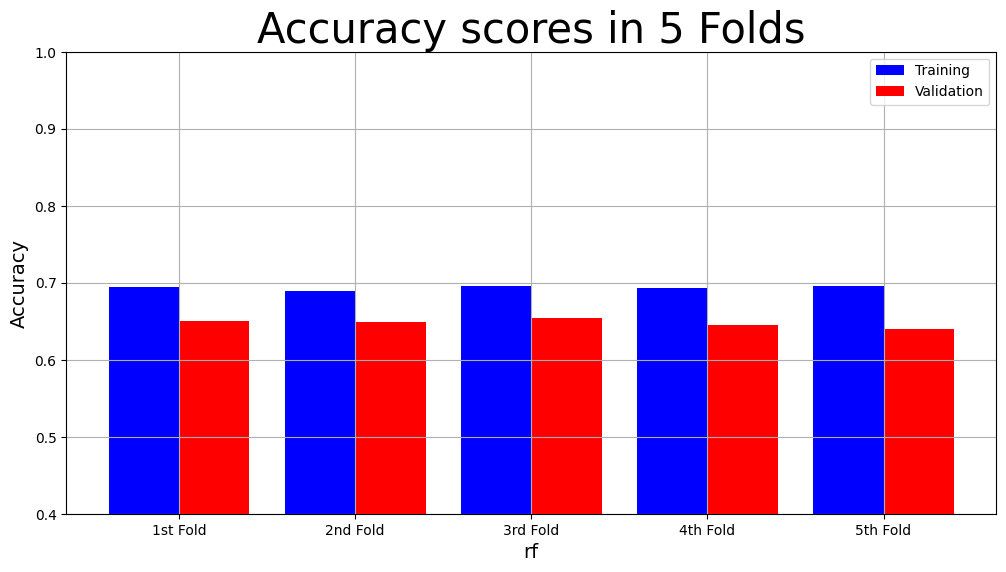

In [91]:
model_name = "rf"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            rf_result["Training Accuracy scores"],
            rf_result["Validation Accuracy scores"])

In [94]:
# evaluate the model

for i in range(len(result["Training Accuracy scores"])):
    print(f"Training Accuracy: {result['Training Accuracy scores'][i]}, Validation Accuracy: {result['Validation Accuracy scores'][i]}")
    print(f"Training Precision: {result['Training Precision scores'][i]}, Validation Precision: {result['Validation Precision scores'][i]}")
    print(f"Training Recall: {result['Training Recall scores'][i]}, Validation Recall: {result['Validation Recall scores'][i]}")
    print(f"Training F1: {result['Training F1 scores'][i]}, Validation F1: {result['Validation F1 scores'][i]}")
    print("="*50)



train_score: 0.8094452464425654, test_score: 0.6577319587628866
Training Accuracy: 0.6945088940448569, Validation Accuracy: 0.65
Training Precision: 0.7396745932415519, Validation Precision: 0.6769964243146603
Training Recall: 0.6058431573552024, Validation Recall: 0.5819672131147541
Training F1: 0.6661031276415892, Validation F1: 0.6258953168044077
Training Accuracy: 0.6890951276102089, Validation Accuracy: 0.6494845360824743
Training Precision: 0.7326670830730794, Validation Precision: 0.6778846153846154
Training Recall: 0.6012301383905689, Validation Recall: 0.5778688524590164
Training F1: 0.660472972972973, Validation F1: 0.6238938053097346
Training Accuracy: 0.6952822892498066, Validation Accuracy: 0.6536082474226804
Training Precision: 0.7373456790123457, Validation Precision: 0.6853658536585366
Training Recall: 0.6122501281394157, Validation Recall: 0.5758196721311475
Training F1: 0.6690002800336041, Validation F1: 0.6258351893095769
Training Accuracy: 0.6936460884134553, Valida

In [95]:
# k-fold cross validation with xgboost
xgb_result = cross_validation(xgb.XGBClassifier(objective="binary:logistic", random_state=42, verbose=1, learning_rate=xgb_best_i, max_depth=xgb_best_j), X_train, y_train, _cv=5)

[14:38:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:38:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:39:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a fa

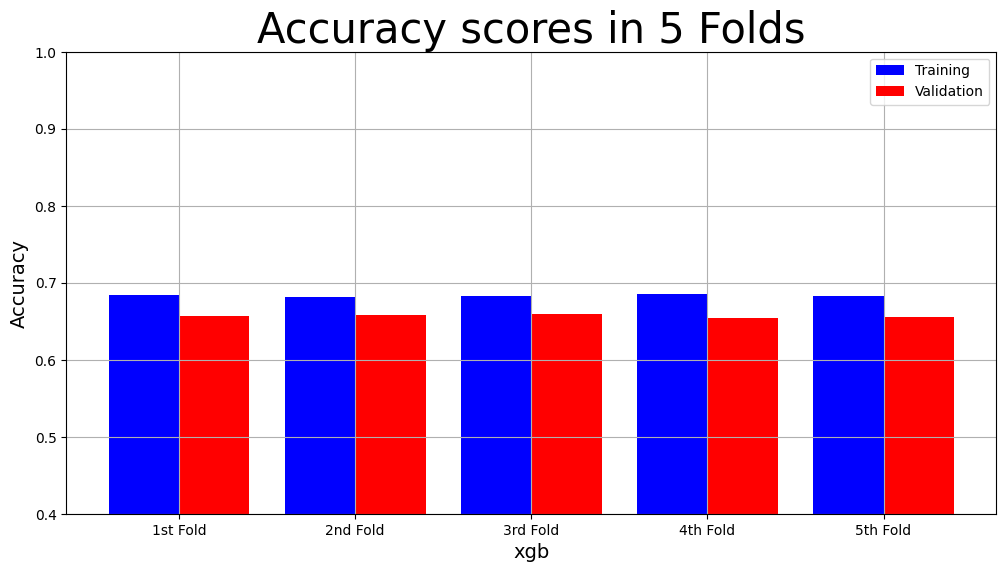

Training Accuracy: 0.6945088940448569, Validation Accuracy: 0.65
Training Precision: 0.7396745932415519, Validation Precision: 0.6769964243146603
Training Recall: 0.6058431573552024, Validation Recall: 0.5819672131147541
Training F1: 0.6661031276415892, Validation F1: 0.6258953168044077
Training Accuracy: 0.6890951276102089, Validation Accuracy: 0.6494845360824743
Training Precision: 0.7326670830730794, Validation Precision: 0.6778846153846154
Training Recall: 0.6012301383905689, Validation Recall: 0.5778688524590164
Training F1: 0.660472972972973, Validation F1: 0.6238938053097346
Training Accuracy: 0.6952822892498066, Validation Accuracy: 0.6536082474226804
Training Precision: 0.7373456790123457, Validation Precision: 0.6853658536585366
Training Recall: 0.6122501281394157, Validation Recall: 0.5758196721311475
Training F1: 0.6690002800336041, Validation F1: 0.6258351893095769
Training Accuracy: 0.6936460884134553, Validation Accuracy: 0.6446621970087674
Training Precision: 0.72467608

In [96]:
# plot the result
model_name = "xgb"
plot_result(model_name,
            "Accuracy",
            "Accuracy scores in 5 Folds",
            xgb_result["Training Accuracy scores"],
            xgb_result["Validation Accuracy scores"])

for i in range(len(xgb_result["Training Accuracy scores"])):
    print(f"Training Accuracy: {xgb_result['Training Accuracy scores'][i]}, Validation Accuracy: {xgb_result['Validation Accuracy scores'][i]}")
    print(f"Training Precision: {xgb_result['Training Precision scores'][i]}, Validation Precision: {xgb_result['Validation Precision scores'][i]}")
    print(f"Training Recall: {xgb_result['Training Recall scores'][i]}, Validation Recall: {xgb_result['Validation Recall scores'][i]}")
    print(f"Training F1: {xgb_result['Training F1 scores'][i]}, Validation F1: {xgb_result['Validation F1 scores'][i]}")
    print("="*50)


In [97]:
# It is obvious that the xgboost model is better than the random forest model, so we choose the xgboost model trained with fold 3 (best one) as our final model
pickle.dump(xgb_result["estimator"][2], open(model_path, 'wb'))